In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTENC

from sklearn.utils import class_weight

from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score,roc_curve, classification_report, confusion_matrix, precision_recall_curve

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV

In [2]:
plt.style.use('seaborn')

## Read Data

In [3]:
data = pd.read_csv("data/data.csv")

In [4]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Balance_over_Salary,Tenure_over_Age,Age_Tenure,CreditScore_over_Age
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.000000,0.047619,40,14.738095
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.744677,0.024390,40,14.829268
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1.401375,0.190476,34,11.952381
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0.000000,0.025641,38,17.923077
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,1.587055,0.046512,41,19.767442


#### Type casting

In [5]:
data.dtypes

CreditScore               int64
Geography                object
Gender                   object
Age                       int64
Tenure                    int64
Balance                 float64
NumOfProducts             int64
HasCrCard                 int64
IsActiveMember            int64
EstimatedSalary         float64
Exited                    int64
Balance_over_Salary     float64
Tenure_over_Age         float64
Age_Tenure                int64
CreditScore_over_Age    float64
dtype: object

In [6]:
data = data.astype({"Geography": "category", "Gender": "category",
                    "NumOfProducts": "category", "IsActiveMember": "category",
                   "HasCrCard": "category"})

In [7]:
data.dtypes

CreditScore                int64
Geography               category
Gender                  category
Age                        int64
Tenure                     int64
Balance                  float64
NumOfProducts           category
HasCrCard               category
IsActiveMember          category
EstimatedSalary          float64
Exited                     int64
Balance_over_Salary      float64
Tenure_over_Age          float64
Age_Tenure                 int64
CreditScore_over_Age     float64
dtype: object

## Split data into train and test set

Separate target and features

In [8]:
X = data.drop(columns="Exited")

y = data["Exited"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=425)

## Oversample Training Data (SMOTE-NC)

---

SMOTE is an oversampling method that balances imbalanced datasets by sampling (with replacement) minority class.
Only training data is oversampled. The test set is untouched.

In [10]:
smote = SMOTENC(categorical_features=(X_train.dtypes == "category").values, random_state=425, n_jobs=-1)

X_train, y_train = smote.fit_resample(X_train, y_train)

## Standardization and One-Hot Encoding

---

We need to standardize the data only after performing train-test split. If we do not so, we may have data leakage. This is the situation when some information leak from the test set into the train set.

In [11]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Balance_over_Salary,Tenure_over_Age,Age_Tenure,CreditScore_over_Age
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.000000,0.047619,40,14.738095
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.744677,0.024390,40,14.829268
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1.401375,0.190476,34,11.952381
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0.000000,0.025641,38,17.923077
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,1.587055,0.046512,41,19.767442


In [12]:
categorical_columns = list(X_train.select_dtypes(include='category').columns)

numerical_columns = list(X_train.select_dtypes(exclude='category').columns)

## Column Transformers
transformers = [('one_hot_encoder', OneHotEncoder(drop='first',dtype='int'), categorical_columns),
                ('standard_scaler', RobustScaler(), numerical_columns)]

X_transformer = ColumnTransformer(transformers, remainder='passthrough')

## Applying Column Transformer

X_train = X_transformer.fit_transform(X_train)

X_test = X_transformer.transform(X_test)

Save feature names after one-hot encoding for feature importances plots

In [13]:
feature_names = list(X_transformer.named_transformers_['one_hot_encoder'].get_feature_names(input_features=categorical_columns))
feature_names = feature_names + numerical_columns

In [14]:
feature_names

['Geography_Germany',
 'Geography_Spain',
 'Gender_Male',
 'NumOfProducts_2',
 'NumOfProducts_3',
 'NumOfProducts_4',
 'HasCrCard_1',
 'IsActiveMember_1',
 'CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'EstimatedSalary',
 'Balance_over_Salary',
 'Tenure_over_Age',
 'Age_Tenure',
 'CreditScore_over_Age']

# Modeling

In [15]:
from helpers import report

In [16]:
confusion_lbs = ['No Churn', 'Churn']

## Logistic Regression

---

Logistic Regression with K-Fold Cross-Validation.

LogisticRegression(class_weight='balanced', intercept_scaling=1.0, max_iter=500,
                   penalty='l1', random_state=0, solver='liblinear')

==============================> TRAIN-TEST DETAILS <==============================

Train Accuracy:  0.8336734693877551
Test Accuracy:  0.8275
--------------------------------------------------
Area Under ROC:  0.8487686453788148
--------------------------------------------------

==============================> CLASSIFICATION REPORT <==============================

              precision    recall  f1-score   support

    No Churn       0.91      0.87      0.89      1593
       Churn       0.56      0.68      0.61       407

    accuracy                           0.83      2000
   macro avg       0.74      0.77      0.75      2000
weighted avg       0.84      0.83      0.83      2000


==============================> CONFUSION MATRIX <==============================


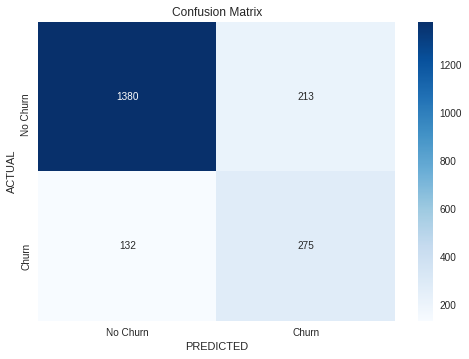


==============================> PLOTS <==============================


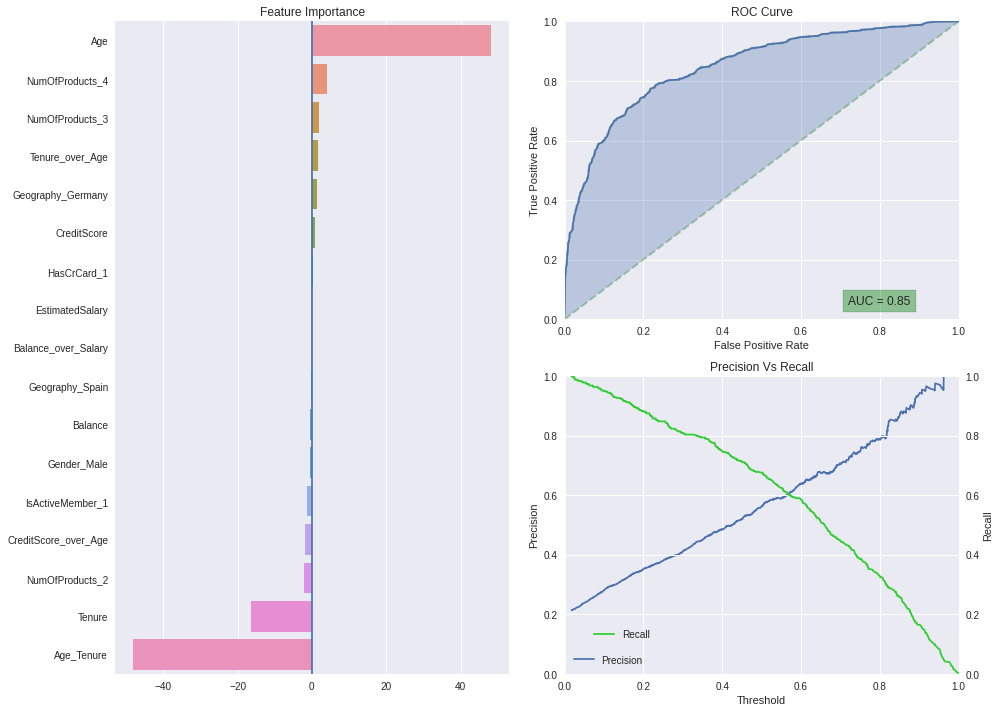

In [17]:
logistic_regression = LogisticRegression(C=1.0,
                                         fit_intercept=True,
                                         penalty='l1',
                                         solver='liblinear',
                                         tol=0.0001,
                                         max_iter=500,
                                         class_weight='balanced',
                                         verbose=0,
                                         intercept_scaling=1.0,
                                         multi_class='auto',
                                         random_state=0)

logistic_regression_cv, logistic_regression_report = report(logistic_regression,
                                                            X_train,
                                                            y_train,
                                                            X_test,
                                                            y_test,
                                                            refit=True,
                                                            importance_plot=True,
                                                            feature_labels=feature_names,
                                                            confusion_labels=confusion_lbs)

## Random Forest

---

Use `RandomizedSearchCV` for searching the best hyper-parameters, then fit the model with these parameters.

#### Optimal parameters

In [18]:
param_data = {'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 40,
 'class_weight': 'balanced',
 'bootstrap': True}

pd.DataFrame.from_dict(param_data, orient="index")

,0
n_estimators,800
min_samples_split,2
min_samples_leaf,1
max_features,auto
max_depth,40
class_weight,balanced
bootstrap,True


### Fit the model with the best paramters

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=40, n_estimators=800, n_jobs=-1,
                       random_state=0)

==============================> TRAIN-TEST DETAILS <==============================

Train Accuracy:  1.0
Test Accuracy:  0.8355
--------------------------------------------------
Area Under ROC:  0.869171945443132
--------------------------------------------------

==============================> CLASSIFICATION REPORT <==============================

              precision    recall  f1-score   support

    No Churn       0.92      0.87      0.89      1593
       Churn       0.58      0.70      0.63       407

    accuracy                           0.84      2000
   macro avg       0.75      0.78      0.76      2000
weighted avg       0.85      0.84      0.84      2000


==============================> CONFUSION MATRIX <==============================


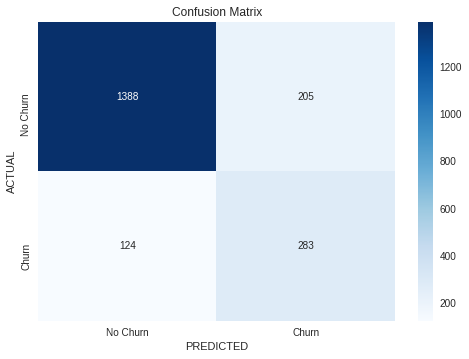


==============================> PLOTS <==============================


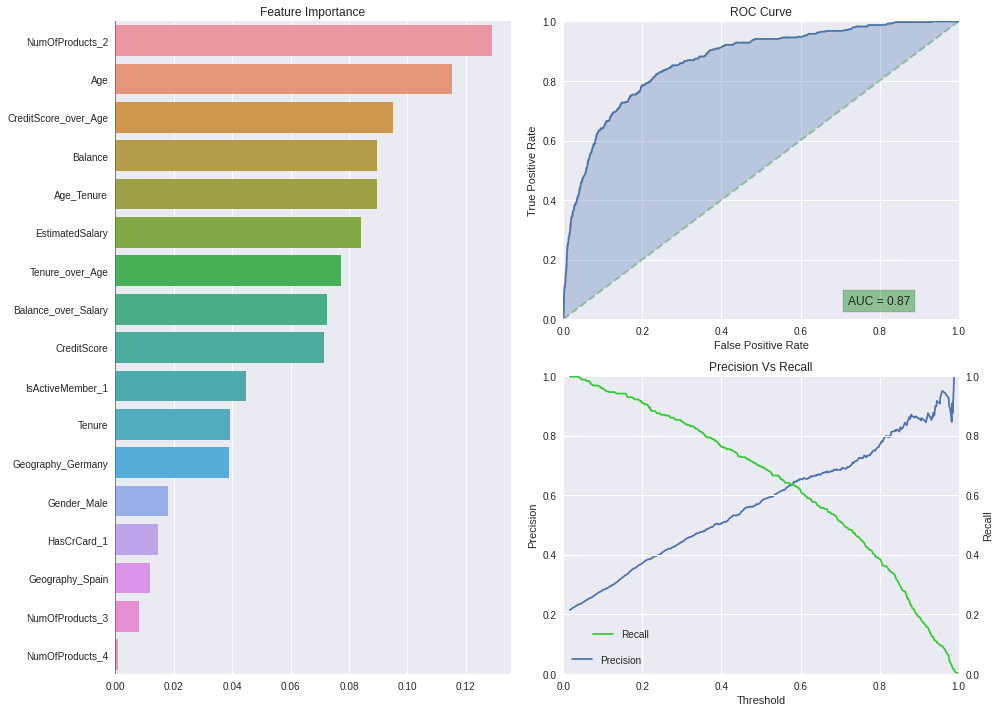

In [19]:
random_forest = RandomForestClassifier(class_weight='balanced',
                                       criterion='entropy',
                                       max_depth=40,
                                       max_features="auto",
                                       n_estimators=800,
                                       min_samples_leaf=1,
                                       min_samples_split=2,
                                       bootstrap=True,
                                       n_jobs=-1,
                                       random_state=0)


random_forest, random_forest_report = report(random_forest,
                                             X_train,
                                             y_train,
                                             X_test,
                                             y_test,
                                             importance_plot=True,
                                             feature_labels=feature_names,
                                             confusion_labels=confusion_lbs)

## Support Vector Machine

---

Use `RandomizedSearchCV` for searching the best hyper-parameters, then fit the model with these parameters.

#### Optimal parameters

In [20]:
param_data = {'kernel': 'rbf', 'gamma': 0.01, 'C': 1000}

pd.DataFrame.from_dict(param_data, orient="index")

,0
kernel,rbf
gamma,0.01
C,1000


### Fit the model with the best paramters

SVC(C=1000, class_weight='balanced', gamma=0.01, probability=True,
    random_state=0)

==============================> TRAIN-TEST DETAILS <==============================

Train Accuracy:  0.8860282574568289
Test Accuracy:  0.85
--------------------------------------------------
Area Under ROC:  0.8501830027253755
--------------------------------------------------

==============================> CLASSIFICATION REPORT <==============================

              precision    recall  f1-score   support

    No Churn       0.90      0.92      0.91      1593
       Churn       0.64      0.58      0.61       407

    accuracy                           0.85      2000
   macro avg       0.77      0.75      0.76      2000
weighted avg       0.85      0.85      0.85      2000


==============================> CONFUSION MATRIX <==============================


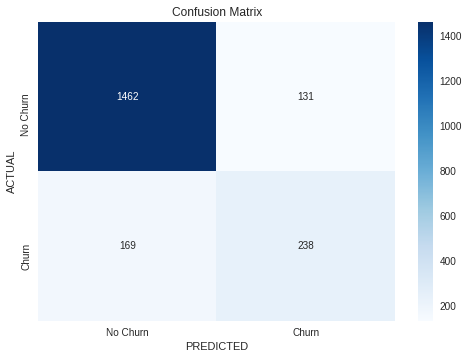


==============================> PLOTS <==============================


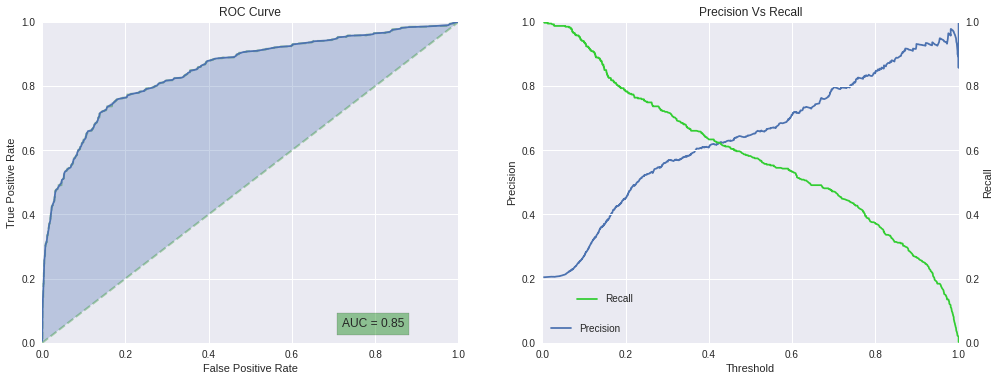

In [21]:
svc_main = SVC(C=1000,
               kernel='rbf',
               gamma=0.01,
               probability=True,
               class_weight='balanced',
               random_state=0)


svc_main, svc_main_report = report(svc_main,
                                   X_train,
                                   y_train,
                                   X_test,
                                   y_test,
                                   importance_plot=True,
                                   feature_labels=feature_names,
                                   confusion_labels=confusion_lbs)

## Model Comparison

In [22]:
from helpers import compare_models

In [23]:
report_list = [logistic_regression_report, 
               random_forest_report,
               svc_main_report]


clf_labels = [rep['clf'].__class__.__name__ for rep in report_list]


clf_labels[-1] = 'SVC'

In [24]:
compare_table, compare_plot = compare_models(y_test,
                                             clf_reports=report_list,
                                             labels=clf_labels)

compare_table

,Train Accuracy,Test Accuracy,ROC Area,Precision,Recall,F1-score
LogisticRegression,0.834,0.828,0.848769,0.563525,0.675676,0.614525
RandomForestClassifier,1.000,0.836,0.869172,0.579918,0.695332,0.632402
SVC,0.886,0.850,0.850183,0.644986,0.584767,0.613402


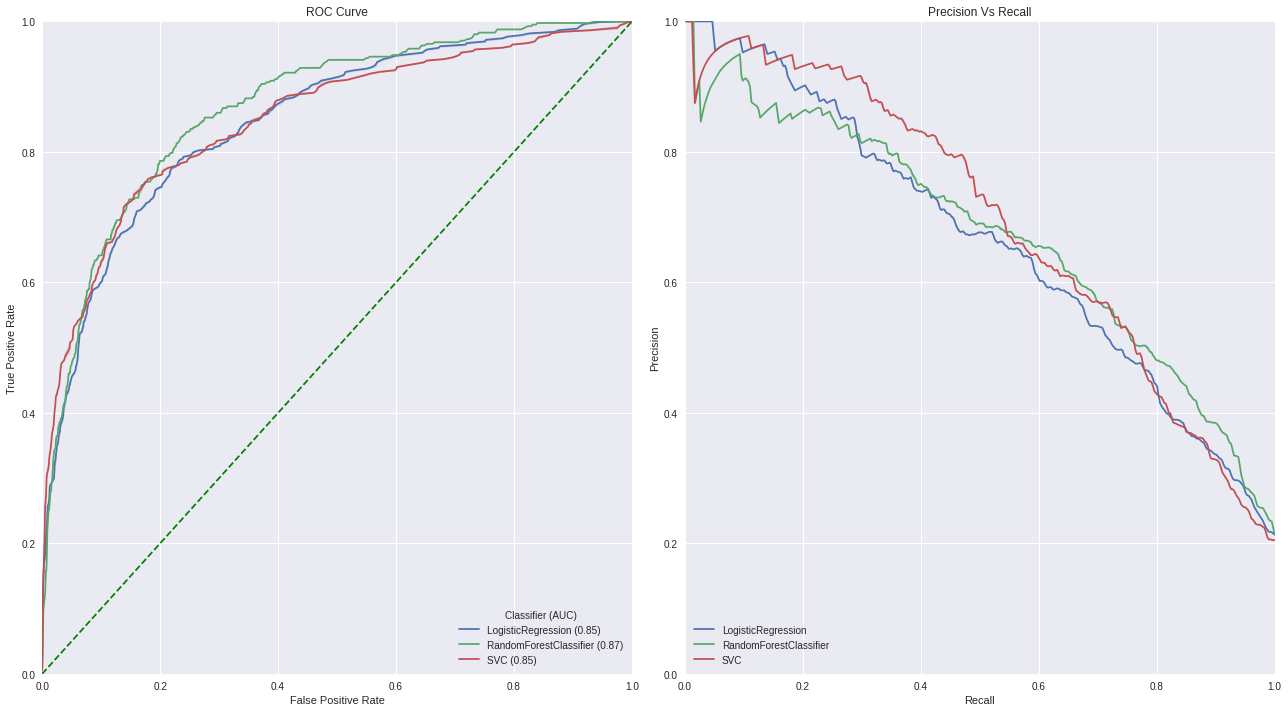

In [25]:
compare_plot

# Survival Analysis

---

Survival analysis is a set of statistical approaches used to determine the time it takes for an event of interest to occur. In our case, the event under interest is if the customer will leave or not and when he/she will leave.

Here, I use following two methods:

* Kaplan-Meier plots to visualize survival curves.

* Cox-proportional hazards regression, to find the effect of different features on survival.



Generally we use two related probabilities to analyze survival data for a subject.

* Survival Function(S)


* Hazard Function (H)

The **survival function** is defined as the probability that an individual survives from the time origin to a specified future time.

The **hazard probability** is the probability that an individual who is under observation at a time t has an event at that time. The hazard function gives us the cumulative probability.

## Kaplan-Meier Estimator

---

For the **Kaplan-Meier** estimator, we only need two features. The first is the target, whether the customer churned or not, and the second is tenure. How long the customer was a client for a bank. This is a good proxy for the time until the event (customer churned) happened.

In [26]:
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

In [27]:
kmf = KaplanMeierFitter()

### Fit the model

In [28]:
kmf.fit(durations=data["Tenure"] * 12, event_observed=data["Exited"])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 10000 total observations, 7963 right-censored observations>

The plot below shows that at time $t=0$, the probability of churn is approximately 1. However, as time passes, the chance of churn decreases with a stepwise pattern.

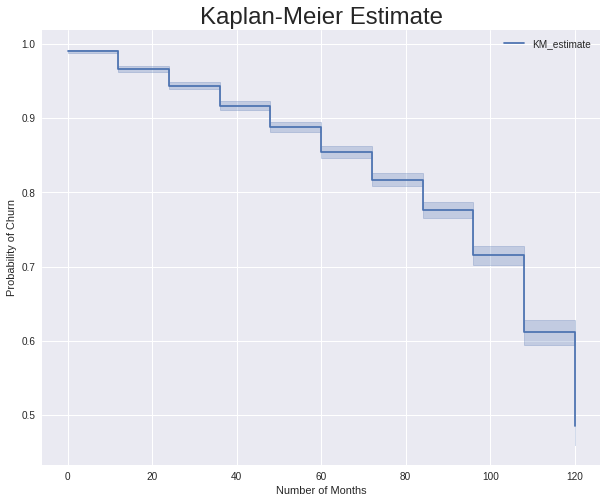

In [29]:
plt.figure(figsize=(10,8))

kmf.plot()

plt.title("Kaplan-Meier Estimate", fontsize=24)
plt.xlabel("Number of Months")
plt.ylabel("Probability of Churn");

We see that, the probability to churn after $6$ month is $0.99$, while after $48$ months it's $0.88$.

In [30]:
pd.DataFrame(kmf.predict([6, 12, 24, 36, 48]))

,KM_estimate
6,0.990500
12,0.966530
24,0.943814
36,0.917024
48,0.888362


### The median number of survival months

---

It provides the number of month where, on average, 50% of the customers not churned or churn. The median is 120 month.

In [31]:
print(f"The median not churning time is {kmf.median_survival_time_}")

The median not churning time is 120.0


The cumulative density plot indicates that as the number of months increases, the probability to churn is increases. Note that after 120 month, the probability is $50 \text{%}$ that the customer churn.

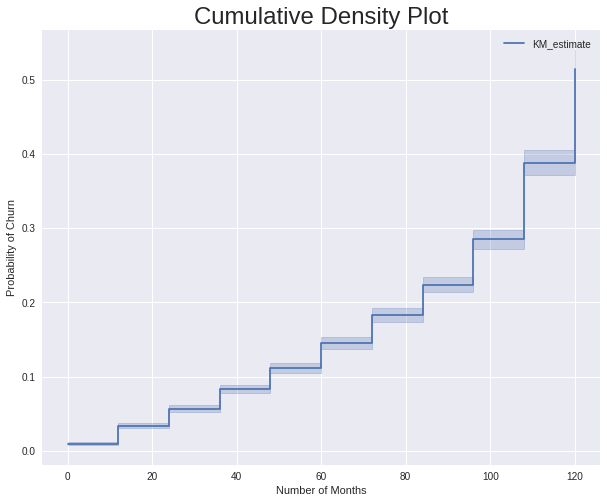

In [32]:
plt.figure(figsize=(10,8))

kmf.plot_cumulative_density()

plt.title("Cumulative Density Plot", fontsize=24)
plt.xlabel("Number of Months")
plt.ylabel("Probability of Churn");

## Cox Proportional Hazard Model

---

The cox-proportional hazard model is a regression model generally used to determine the relationship between the survival time of a subject and one or more predictor variables. In short, we want to find out how different parameters like age, credit score, Salary, affects the survival time of a subject.

In [35]:
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Balance_over_Salary,Tenure_over_Age,Age_Tenure,CreditScore_over_Age,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0.000000,0.047619,40,14.738095,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0.744677,0.024390,40,14.829268,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1.401375,0.190476,34,11.952381,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0.000000,0.025641,38,17.923077,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1.587055,0.046512,41,19.767442,0,1,0


In [34]:
data = pd.get_dummies(data=data, columns=["Geography", "Gender"], drop_first=True)

We have to remove features, which are calculated using `Tenure` variable. Since, `Tenure` is used as dependent variable, there we may introduce high correlation and the model may not converge.

In [36]:
columns_to_drop = ["Tenure_over_Age", "Age_Tenure"]

cox_data = data.drop(columns=columns_to_drop)

In [38]:
cox_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Balance_over_Salary,CreditScore_over_Age,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0.000000,14.738095,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0.744677,14.829268,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1.401375,11.952381,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0.000000,17.923077,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1.587055,19.767442,0,1,0


In [39]:
cph = CoxPHFitter()


cph.fit(cox_data, duration_col='Tenure', event_col='Exited')


cph.print_summary() 

<lifelines.CoxPHFitter: fitted with 10000 total observations, 7963 right-censored observations>
             duration col = 'Tenure'
                event col = 'Exited'
      baseline estimation = breslow
   number of observations = 10000
number of events observed = 2037
   partial log-likelihood = -16416.15
         time fit was run = 2021-02-20 09:59:16 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
CreditScore            0.00       1.00       0.00             0.00             0.01                 1.00                 1.01
Age                   -0.01       0.99       0.01            -0.03            -0.00                 0.97                 1.00
Balance                0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
NumOfProducts         -0.07       0.93       0.04            -0.14             0.01                 0.87                 1.01
HasCrCard             -0.06       0.94       0.05            -0.15             0.04                 0.86                 1.04
IsActiveMember        -0.67       0.51       0.05            -0.77            -0.58                 0.47                 0.56
EstimatedSalary        0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Balance_over_Salary    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
CreditScore_over_Age  -0.19       0.83       0.02            -0.23            -0.16                 0.80                 0.86
Geography_Germany      0.48       1.62       0.05             0.38             0.59                 1.46                 1.80
Geography_Spain        0.05       1.05       0.06            -0.07             0.17                 0.93                 1.18
Gender_Male           -0.38       0.68       0.04            -0.47            -0.29                 0.63                 0.75

                          z      p   -log2(p)
covariate                                    
CreditScore            8.11 <0.005      50.86
Age                   -2.10   0.04       4.82
Balance                4.37 <0.005      16.27
NumOfProducts         -1.79   0.07       3.77
HasCrCard             -1.20   0.23       2.12
IsActiveMember       -14.17 <0.005     148.96
EstimatedSalary        0.05   0.96       0.06
Balance_over_Salary    1.78   0.08       3.72
CreditScore_over_Age -10.15 <0.005      78.05
Geography_Germany      8.86 <0.005      60.08
Geography_Spain        0.84   0.40       1.31
Gender_Male           -8.50 <0.005      55.59
---
Concordance = 0.73
Partial AIC = 32856.29
log-likelihood ratio test = 1287.93 on 12 df
-log2(p) of ll-ratio test = 889.29

In the summary table above, we see that six variables `CreditScore`,  `Balance`, `IsActiveMember`, `CreditScore_over_Age`, `Geography_Germany`, and `Gender_Male` are statistically significant.

The column `exp(coef)` measures the hazard rate. Let denote hazard rate as $HR$, then

$$HR = 1 : \text{No effext}$$

$$HR < 1 : \text{Reduction in Hazard}$$

$$HR > 1 : \text{Increase in Hazard}$$


For `Gender_Male` variable hazard rate is 0.68. This indicates strong relationship between the customer's gender and decreased risk of churn.

For `Geography_Germany` variable hazard rate is 1.62. This indicates strong relationship between the customer's origin and increased risk of churn.

**The below graph shows which factor affects the most to the churn, positively or negatively**.

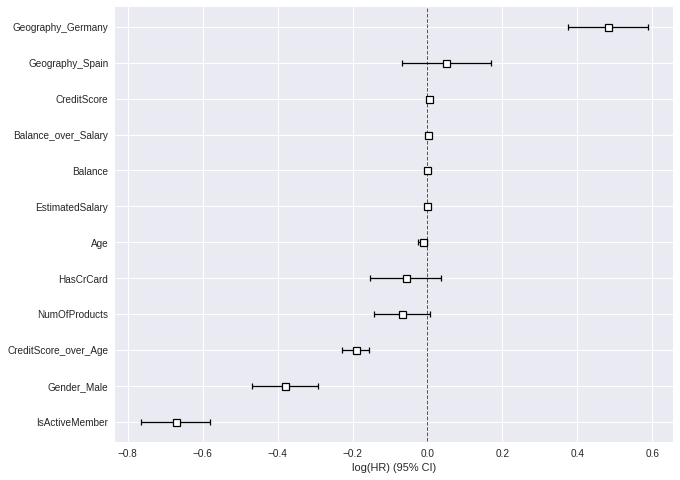

In [40]:
plt.figure(figsize=(10,8))

cph.plot();